# EDA of POLITISKY24 dataset

This notebook is a compact exploratory analysis of a **stance-annotated** dataset with posts targeting political entities.

The goal is to document:
- what fields are present and how complete they are,
- how stance labels are distributed per target entity,
- how confidence scores and text lengths vary across targets/stances,
- which hashtags show up most often for each target (Trump vs Harris).


In [1]:
import numpy as np
import pandas as pd

df = pd.read_parquet("/content/llm_annotated_full_user_stance_dataset.parquet")
print(len(df))


16044


## Quick peek at the raw table

We print `df` to confirm the schema and the *shape of individual rows*.

A few things to notice from this preview:
- `Context` is stored as a field that may contain text (or text-like content) per row.
- `TargetEntity` indicates which entity the post is about (used later for splits).
- `StanceLabel` and `ConfidenceLevel` are the main annotation outputs used in the plots below.


In [4]:
df

,UserId,TargetEntity,Context,LLMAnswerContent,LLMAnswerUsage,SourcePosts,Spans,Reason,StanceLabel,ConfidenceLevel
0,9,Harris,[Assuming Harris is the pick. Biden might have...,"{\n ""source_tweets"": [\n ""Assuming H...","{'input_tokens': 888, 'output_tokens': 351, 't...",[Assuming Harris is the pick. Biden might have...,[hope there's been arrangements to make her th...,The user expresses a preference for Kamala Har...,Favor,0.85
1,9,Trump,[Gonna fucking Battle Royale us into a Trump p...,"{\n ""source_tweets"": [\n ""Gonna fuck...","{'input_tokens': 810, 'output_tokens': 277, 't...",[Gonna fucking Battle Royale us into a Trump p...,[Gonna fucking Battle Royale us into a Trump p...,The tweets express a critical view of Donald T...,Against,0.95
2,10,Harris,"[Kamala/Harris, Kamala Harris is very good at ...","{\n ""source_tweets"": [\n ""Kamala Har...","{'input_tokens': 803, 'output_tokens': 326, 't...","[Kamala Harris is very good at this., I think ...","[Kamala Harris is very good at this., I think ...",The tweets express strong support for Kamala H...,Favor,0.95
3,10,Trump,"[Not to get too political on here, but I reall...","{\n ""source_tweets"": [""Not to get too polit...","{'input_tokens': 808, 'output_tokens': 217, 't...","[Not to get too political on here, but I reall...",[I really hope Donald Trump does not become pr...,The user expresses clear opposition to Donald ...,Against,0.95
4,49,Harris,[To any and ALL MAGA calling for unity and the...,"{\n ""source_tweets"": [""To any and ALL MAGA ...","{'input_tokens': 859, 'output_tokens': 357, 't...",[To any and ALL MAGA calling for unity and the...,[I will NEVER unite with you. #NoUnityWithMAGA...,The user expresses strong opposition to MAGA a...,Against,0.85
...,...,...,...,...,...,...,...,...,...,...
16039,401337,Trump,"[Love Obama, Pretty much the whole world hates...","{\n ""stance"": ""Neither"",\n ""reason"": ""Th...","{'input_tokens': 740, 'output_tokens': 85, 'to...",None,None,The tweets provided do not directly express a ...,Neither,NaN
16040,401380,Harris,[Boycott Elon Musk! #FuckMusk #FuckTrump #res...,"{\n ""stance"": ""Neither"",\n ""reason"": ""Th...","{'input_tokens': 838, 'output_tokens': 65, 'to...",None,None,The tweets provided do not contain any direct ...,Neither,NaN
16041,401380,Trump,[It appears to me that Trump's picks should al...,"{\n ""source_tweets"": [\n ""Boycott El...","{'input_tokens': 783, 'output_tokens': 278, 't...",[Boycott Elon Musk! #FuckMusk #FuckTrump #res...,"[#FuckTrump, We need protection from Trump., T...",The tweets contain strong negative sentiments ...,Against,0.95
16042,401391,Harris,"[I HATE VIC FONTAINE!, “Kamala Harris Oblitera...","{\n ""stance"": ""Neither"",\n ""reason"": ""Th...","{'input_tokens': 810, 'output_tokens': 86, 'to...",None,None,The tweets provided do not contain clear or di...,Neither,NaN


## Basic completeness check (rows, columns, missing values)

This cell prints:
- total rows: **16,044**
- the column list, and
- missing-value counts per column.

In this dataset, the biggest gaps are:
- `SourcePosts`: **5,003** missing
- `Spans`: **5,003** missing
- `ConfidenceLevel`: **4,961** missing
- `Reason`: **12** missing

Everything else shown is complete (0 missing).


In [2]:

print("Number of rows:", len(df))
print("\nColumns:")
print(df.columns)

print("\nMissing values per column:")
print(df.isna().sum())


Number of rows: 16044

Columns:
Index(['UserId', 'TargetEntity', 'Context', 'LLMAnswerContent',
       'LLMAnswerUsage', 'SourcePosts', 'Spans', 'Reason', 'StanceLabel',
       'ConfidenceLevel'],
      dtype='object')

Missing values per column:
UserId                 0
TargetEntity           0
Context                0
LLMAnswerContent       0
LLMAnswerUsage         0
SourcePosts         5003
Spans               5003
Reason                12
StanceLabel            0
ConfidenceLevel     4961
dtype: int64


## Stance distribution per target entity

We build a contingency table (`crosstab`) of **TargetEntity × StanceLabel** and plot it as a stacked bar chart.
This keeps the analysis strictly at the level of “how many examples of each stance do we have for each target?”


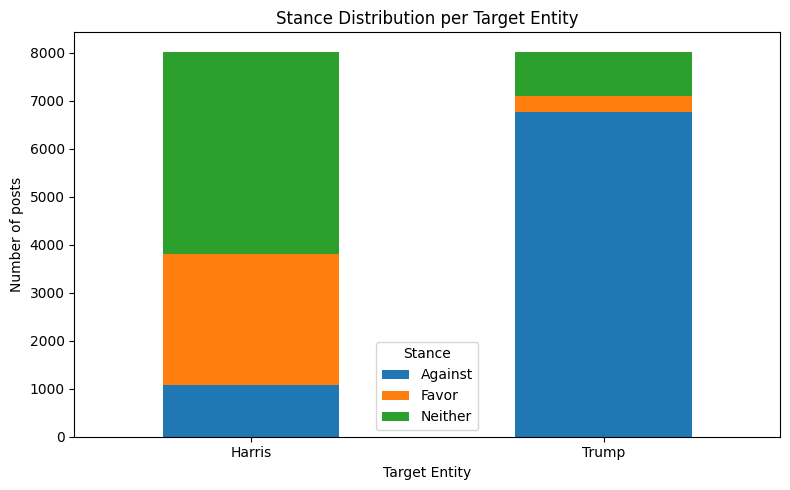

In [5]:
import matplotlib.pyplot as plt

entity_stance = pd.crosstab(df['TargetEntity'], df['StanceLabel'])

entity_stance.plot(
    kind='bar',
    stacked=True,
    figsize=(8,5)
)

plt.title("Stance Distribution per Target Entity")
plt.xlabel("Target Entity")
plt.ylabel("Number of posts")
plt.xticks(rotation=0)
plt.legend(title="Stance")
plt.tight_layout()
plt.show()


## ConfidenceLevel by target and stance

Here we visualize `ConfidenceLevel` split by:
- `TargetEntity` on the x-axis, and
- `StanceLabel` as the hue (color grouping).

Important context from the earlier missing-value table: `ConfidenceLevel` is missing for **4,961** rows, so this plot reflects the subset where confidence is available.


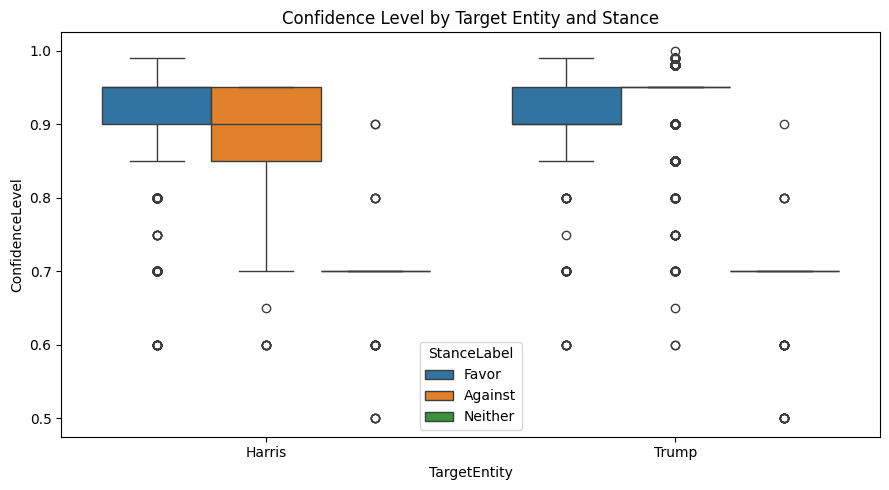

In [6]:
import seaborn as sns

plt.figure(figsize=(9,5))
sns.boxplot(
    x='TargetEntity',
    y='ConfidenceLevel',
    hue='StanceLabel',
    data=df
)
plt.title("Confidence Level by Target Entity and Stance")
plt.tight_layout()
plt.show()


## Text length by target and stance

We create a simple length proxy:

- `text_len = df["Context"].str.len()`

Then we plot `text_len` by `TargetEntity` and `StanceLabel`.  
This is meant as a lightweight check for whether some targets/stances tend to have longer contexts in the dataset.


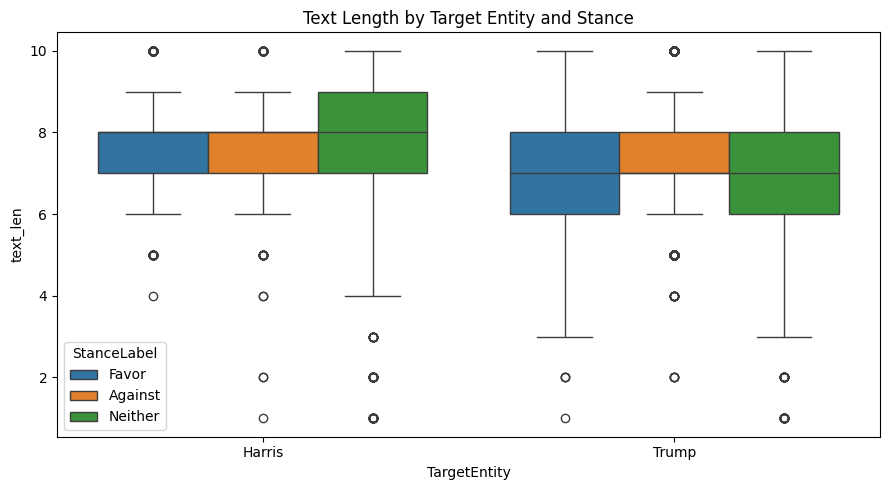

In [9]:
df['text_len'] = df['Context'].str.len()

plt.figure(figsize=(9,5))
sns.boxplot(
    x='TargetEntity',
    y='text_len',
    hue='StanceLabel',
    data=df
)
plt.title("Text Length by Target Entity and Stance")
plt.tight_layout()
plt.show()


## Hashtags: extraction and counting

To look at “topic markers” in the text, we extract hashtags using a regex (`#\w+`).

We build separate hashtag frequency counters for:
- posts targeting **Trump**, and
- posts targeting **Harris**.

Then we plot the top 10 hashtags for each target.


In [12]:
import re
df['text'] = df['Context'].apply(lambda x: ' '.join(x) if isinstance(x, (list, np.ndarray)) else str(x))
df['hashtags'] = df['text'].apply(lambda x: re.findall(r"#\w+", x))


In [ ]:
from collections import Counter

def count_tags(subdf):
    return Counter(tag for tags in subdf['hashtags'] for tag in tags)

trump_tags = count_tags(df[df['TargetEntity'] == 'Trump'])
harris_tags = count_tags(df[df['TargetEntity'] == 'Harris'])


### Top hashtags per target (bar charts)

This figure shows the **10 most frequent hashtags** for Trump-targeting posts and for Harris-targeting posts, based on the regex extraction above.


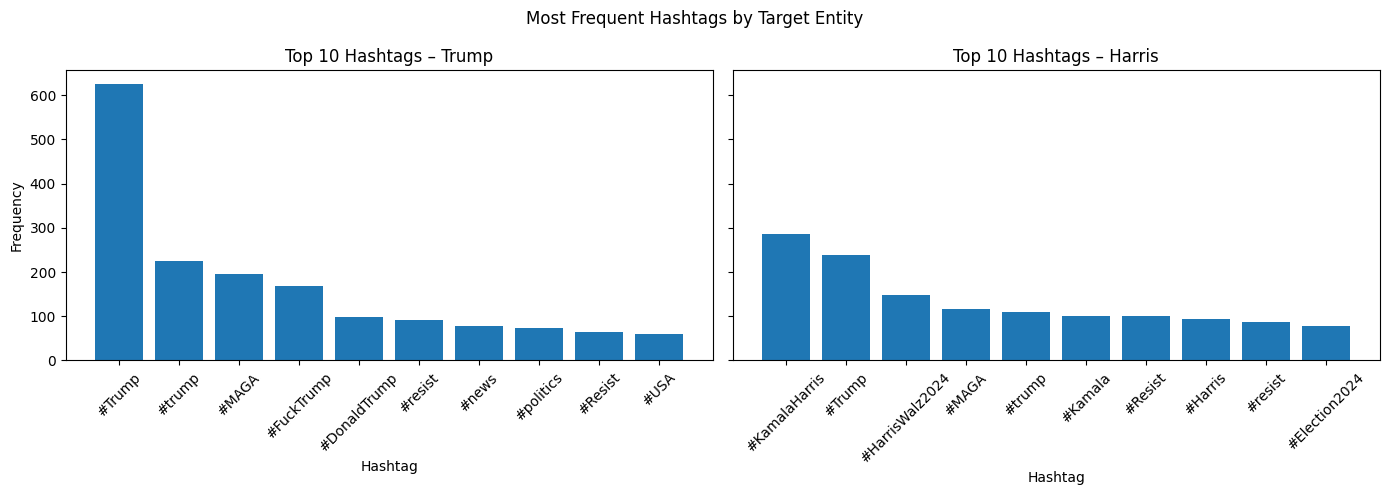

In [14]:

trump_top = trump_tags.most_common(10)
harris_top = harris_tags.most_common(10)

trump_labels, trump_counts = zip(*trump_top)
harris_labels, harris_counts = zip(*harris_top)

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

axes[0].bar(trump_labels, trump_counts)
axes[0].set_title("Top 10 Hashtags – Trump")
axes[0].set_xlabel("Hashtag")
axes[0].set_ylabel("Frequency")
axes[0].tick_params(axis='x', rotation=45)

axes[1].bar(harris_labels, harris_counts)
axes[1].set_title("Top 10 Hashtags – Harris")
axes[1].set_xlabel("Hashtag")
axes[1].tick_params(axis='x', rotation=45)

plt.suptitle("Most Frequent Hashtags by Target Entity")
plt.tight_layout()
plt.show()
